# Undersampling: Condensed Nearest Neighbor

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours
from utils import load_csv_data
from sklearn.decomposition import PCA

In [2]:
X_train_cat,X_test_cat,y_train_cat,y_test_cat = load_csv_data('imbalanced_dataset_cat')

## Undersampling

In [3]:
np.unique(y_test_cat, return_counts=True)

(array([0, 1], dtype=int64), array([19201,  1812], dtype=int64))

In [4]:
print(f'Before undersampling: {np.unique(y_train_cat, return_counts=True)}')
cnn = EditedNearestNeighbours(n_jobs=-1, n_neighbors=10)
X_train, y_train = cnn.fit_resample(X_train_cat, y_train_cat)
print(f'After undersampling{np.unique(y_train, return_counts=True)}')

Before undersampling: (array([0, 1], dtype=int64), array([57600,  5436], dtype=int64))
After undersampling(array([0, 1], dtype=int64), array([37991,  5436], dtype=int64))


In [5]:
np.savez('edited_NN.npz', X_train=X_train, y_train=y_train)

In [8]:
def plot_pca(X_pca, y_train):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

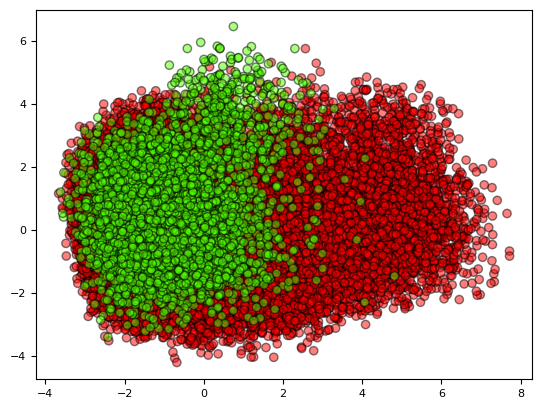

In [9]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
plot_pca(X_train_pca, y_train)

## Model Selection

In [12]:
from sklearn.model_selection import RandomizedSearchCV
# DECISION TREE
parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24,26,30,35,40,45,50,55,60,70,80,90,100,110,120,140]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = RandomizedSearchCV(
    dtc, 
    parameters,
    n_iter=500,
    scoring='f1_macro', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
selected = clf.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
DecisionTreeClassifier(max_depth=20, min_samples_split=50, random_state=8)
{'min_samples_split': 50, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'}
0.8417642660290495


In [11]:
# decision tree selected model
model = DecisionTreeClassifier(max_depth=110, min_samples_leaf=2, min_samples_split=100,
                       random_state=8)
y_pred = cross_val_predict(model, X_train, y_train, cv=5)
y_pred_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')

print(classification_report(y_train, y_pred))
#plot_roc(y_train, y_pred_proba)
#plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
#plt.show()

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     37991
           1       0.75      0.57      0.65      5436

    accuracy                           0.92     43427
   macro avg       0.85      0.77      0.80     43427
weighted avg       0.92      0.92      0.92     43427



In [12]:
feat_dec = {i:attr for attr,i in zip(X_train_cat.columns, range(len(list(X_train_cat.columns))))}
model = DecisionTreeClassifier(max_depth=110, min_samples_leaf=2, min_samples_split=100,
                       random_state=8)
model.fit(X_train, y_train)
feature_importance = [{'name': name, 'importance': imp} for name, imp in zip(X_train_cat.columns, model.feature_importances_)]
feature_importance = sorted(feature_importance, key= lambda x: x['importance'], reverse=True)
pd.DataFrame(feature_importance[:20])

,name,importance
0,speechiness,0.463141
1,instrumentalness,0.049923
2,danceability,0.037451
3,acousticness,0.037362
4,duration_ms,0.036465
5,emo,0.031943
6,sad,0.028488
7,metalcore,0.024398
8,energy,0.023439
9,valence,0.023148


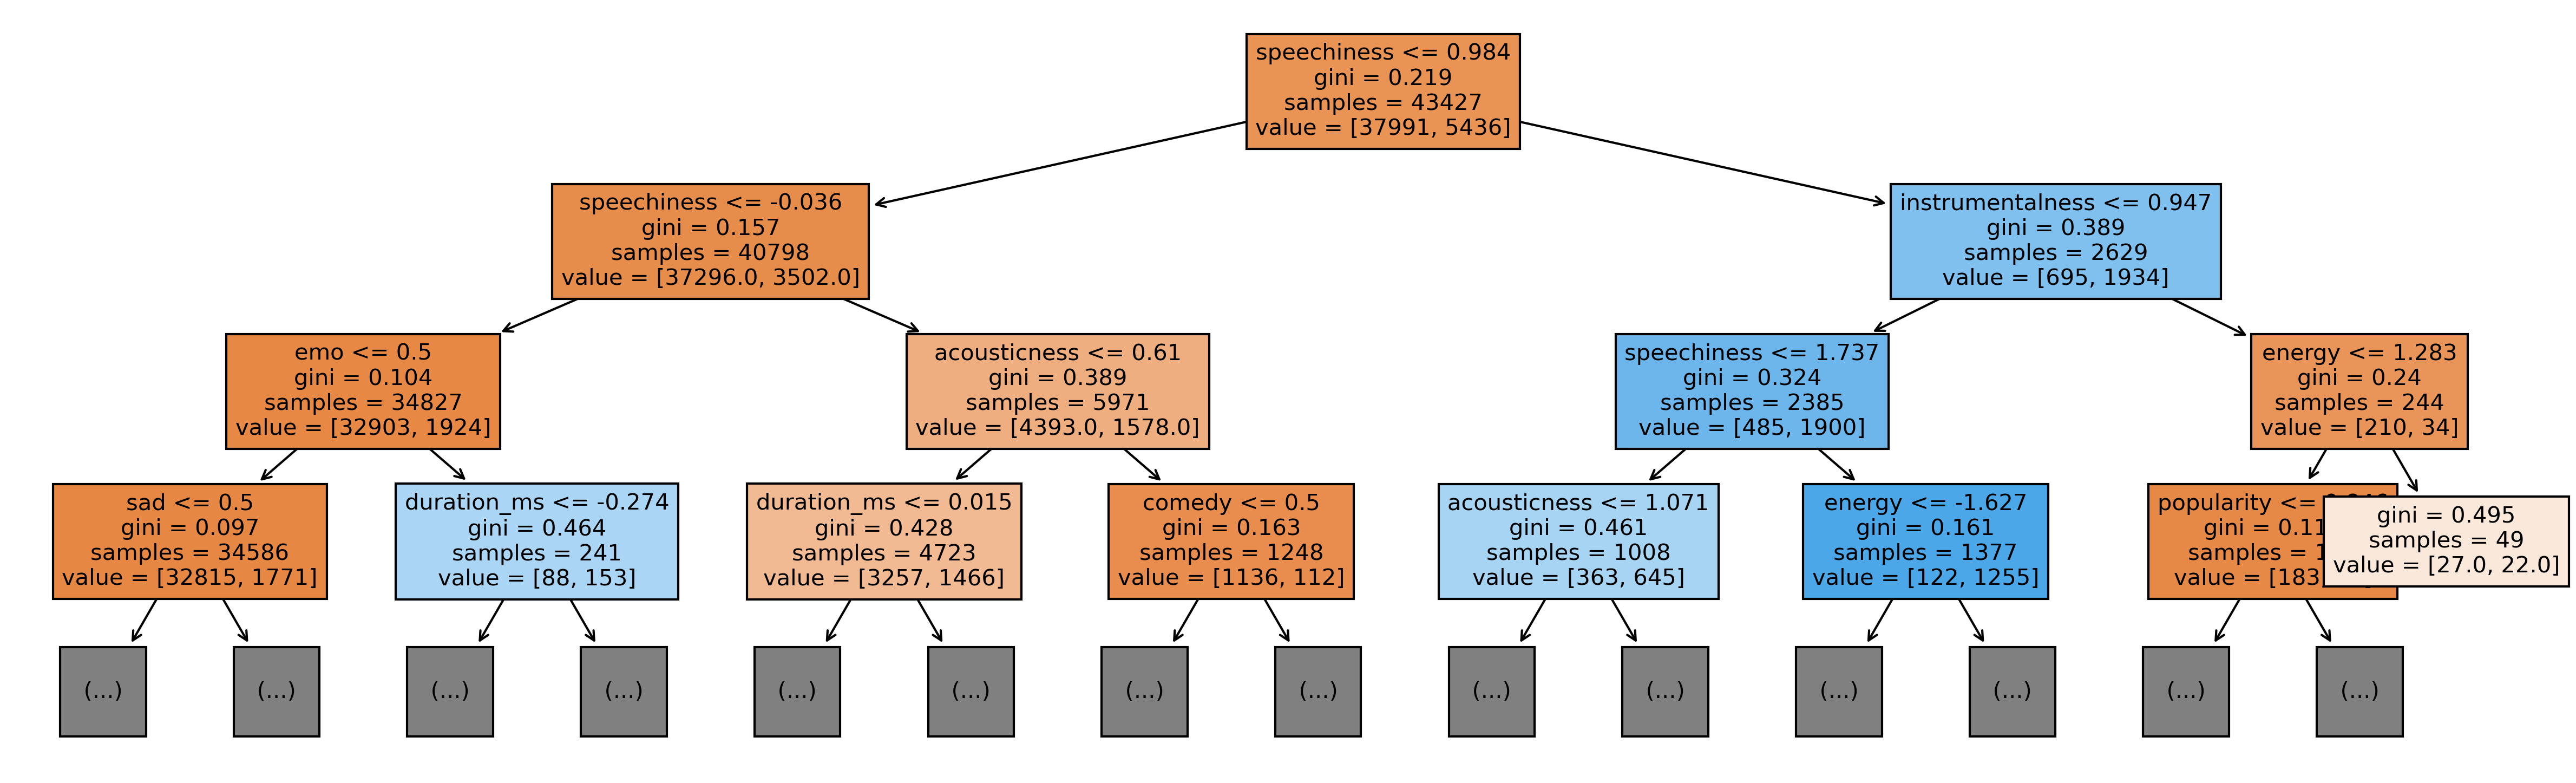

In [13]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 6), dpi=300)
plot_tree(model, feature_names=X_train_cat.columns, filled=True, max_depth=3, fontsize=10)
plt.show()

## Test

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     19201
           1       0.37      0.56      0.44      1812

    accuracy                           0.88     21013
   macro avg       0.66      0.73      0.69     21013
weighted avg       0.91      0.88      0.89     21013



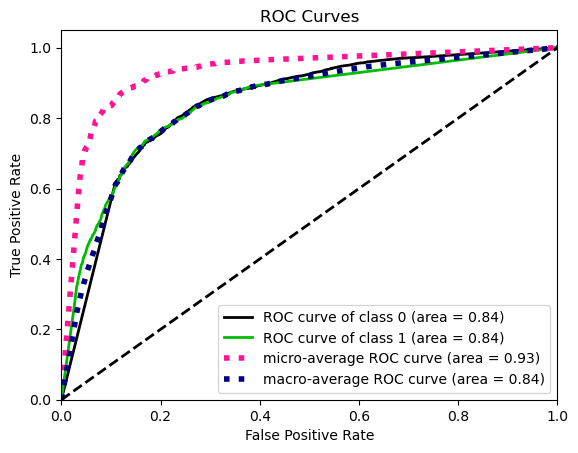

In [7]:
model = DecisionTreeClassifier(max_depth=110, min_samples_leaf=2, min_samples_split=100,
                       random_state=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_cat)
y_pred_proba = model.predict_proba(X_test_cat)

print(classification_report(y_test_cat, y_pred))
plot_roc(y_test_cat, y_pred_proba)
plt.legend(loc='lower right',prop={'size': 10})
plt.show()